# Comparison of KF2, KF3, KF4, KF4d algorithms ( Filter outputs )

A high-speed IBG (IMU + Baro+GPS) data log was recorded while moving the gps-vario up and down. An IBG data log contains IMU AHRS data recorded at 500 samples/sec, Baro z-altitude data at 50 samples/sec and (if available) GPS data at 10 samples/sec. 

This sample log was obtained indoors without GPS reception as we are only interested in testing the Kalman Filtering algorithms that uses altitude and gravity-compensated acceleration data to estimate altitude and climb/sink rate.

An MS5611 barometric pressure sensor and MPU9250 9-DOF IMU generated the sensor data. 

The offline algorithm comparison code was compiled and executed in an Ubuntu 20.04 terminal.

In `config.h` choose the algorithm to run and set LOG_INPUT_OUTPUT to 1.

E.g. if you want to run the KF2 algorithm,
```
// choose one of the following tests
// print the kalman filter P covariance matrix Pzz and Pvv elements, for all samples
#define LOG_CONVERGENCE    0
// print the baro sensor-derived altitude cm, and kalman filter estimates for z and v, for all samples
#define LOG_INPUT_OUTPUT   1

// choose one of the following algorithms  
// for LOG_CONVERGENCE run, only KF3 and KF4 are valid
#define USE_KF2 1
#define USE_KF3 0
#define USE_KF4 0

// For KF4 algorithm, set to 0, the acceleration and bias variances are configured as constants.
// For KF4d algorithm, set this to 1. It dynamically adds uncertainty to the Pvv and
// Pbb covariance elements depending on the magnitude of the environmental accelerations measured.
#define KF4_USE_DYNAMIC_ACCEL_BIAS_VARIANCE 1

```
Build the code :
```
g++ -o kf_compare kf_compare.cpp kalmanfilter2.cpp kalmanfilter3.cpp kalmanfilter4.cpp imu.cpp ringbuf.cpp -lm
```
Generate the results :
```
./kf_compare ./ms5611_datalog > kf2_ms5611_inout.txt
```

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt

# Load sensor altitude samples, KF2 algorithm filter outputs z, v

In [2]:
z = []
z_kf2 = []
v_kf2 = []
with open('kf2_ms5611_inout.txt', newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=' ')
    for row in csvreader:
        z.append(float(row[0]))
        z_kf2.append(float(row[1]))
        v_kf2.append(float(row[2]))
z = np.array(z)        
z_kf2 = np.array(z_kf2)
v_kf2 = np.array(v_kf2)        

# Load KF3 algorithm filter outputs z, v

In [3]:
z_kf3 = []
v_kf3 = []
with open('kf3_ms5611_inout.txt', newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=' ')
    for row in csvreader:
        z_kf3.append(float(row[1]))
        v_kf3.append(float(row[2]))
z_kf3 = np.array(z_kf3)
v_kf3 = np.array(v_kf3)        

# Load KF4 algorithm filter outputs z, v

In [4]:
z_kf4 = []
v_kf4 = []
with open('kf4_ms5611_inout.txt', newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=' ')
    for row in csvreader:
        z_kf4.append(float(row[1]))
        v_kf4.append(float(row[2]))
z_kf4 = np.array(z_kf4)
v_kf4 = np.array(v_kf4)   

# Load KF4d algorithm filter outputs z, v

In [5]:
z_kf4_d = []
v_kf4_d = []
with open('kf4d_ms5611_inout.txt', newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=' ')
    for row in csvreader:
        z_kf4_d.append(float(row[1]))
        v_kf4_d.append(float(row[2]))
z_kf4_d = np.array(z_kf4_d)
v_kf4_d = np.array(v_kf4_d)   

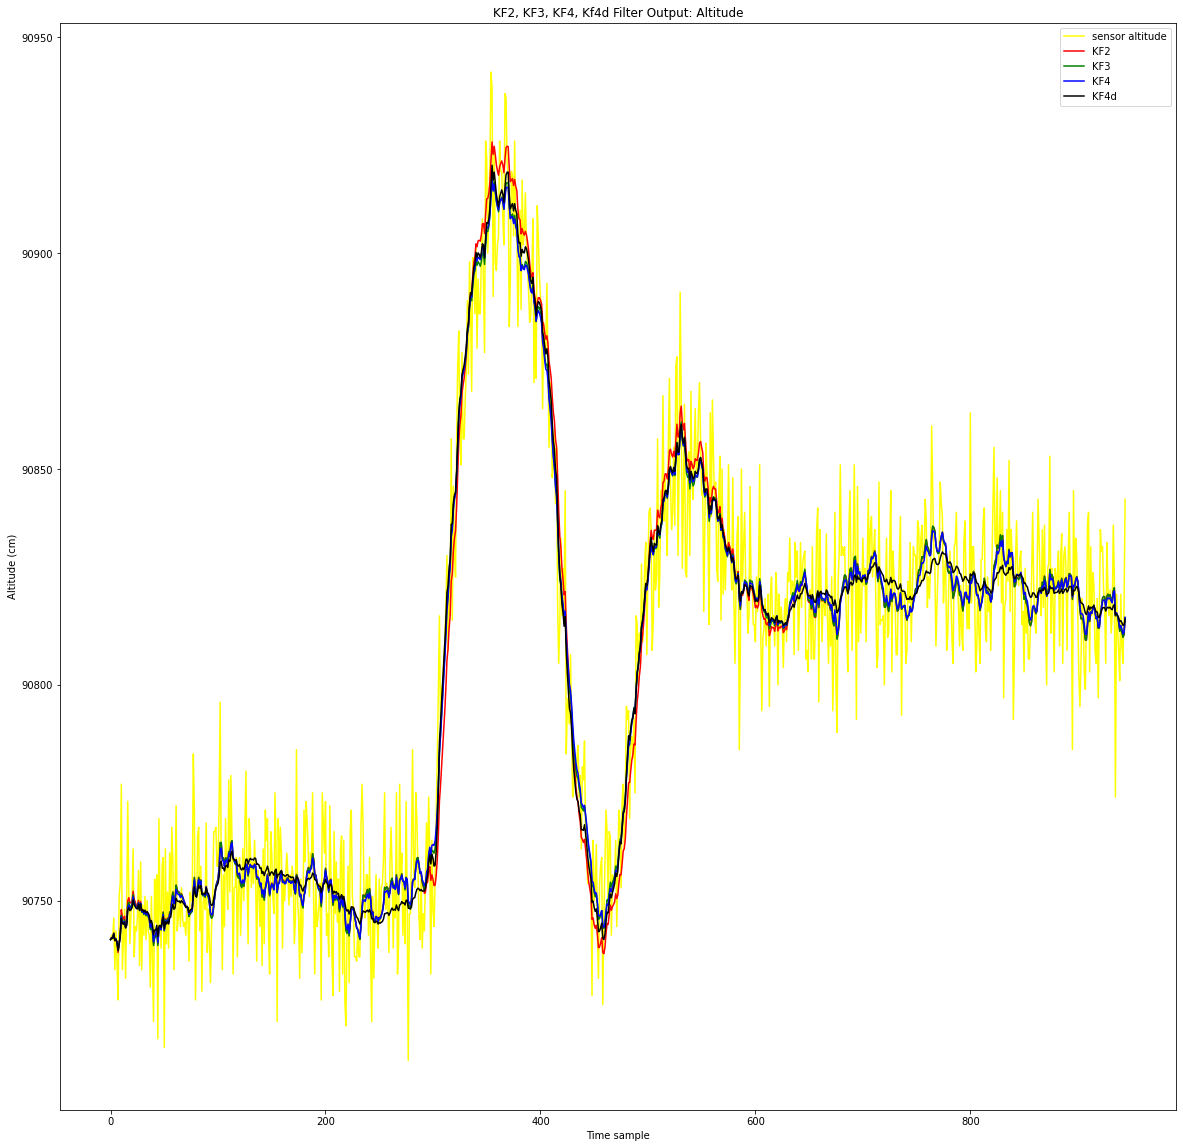

In [6]:
# enlarge the plot size to show more detail
plt.rcParams["figure.figsize"]=20,20

# Plot the MS5611 barometric pressure sensor derived altitude samples in red
plt.plot(z, color='yellow', label='sensor altitude')

# KF2 filter only uses the altitude samples
plt.plot(z_kf2, color='red', label='KF2')

# KF3 filter fuses altitude and gravity-compensated acceleration data
plt.plot(z_kf3, color='green', label='KF3')

# KF4 filter fuses altitude and gravity-compensated acceleration data
plt.plot(z_kf4, color='blue', label='KF4')

# KF4 filter fuses altitude and gravity-compensated acceleration data, dynamically adds uncertainty to
# Pvv and Pbb covariance elements depending on the external acceleration magnitude
plt.plot(z_kf4_d, color='black', label='KF4d')

plt.title('KF2, KF3, KF4, Kf4d Filter Output: Altitude')
plt.legend()
plt.xlabel('Time sample')
plt.ylabel('Altitude (cm)')

plt.show()


# Altitude output :  Zoom in window

KF2 shows a response lag, while KF3 and KF4 do not

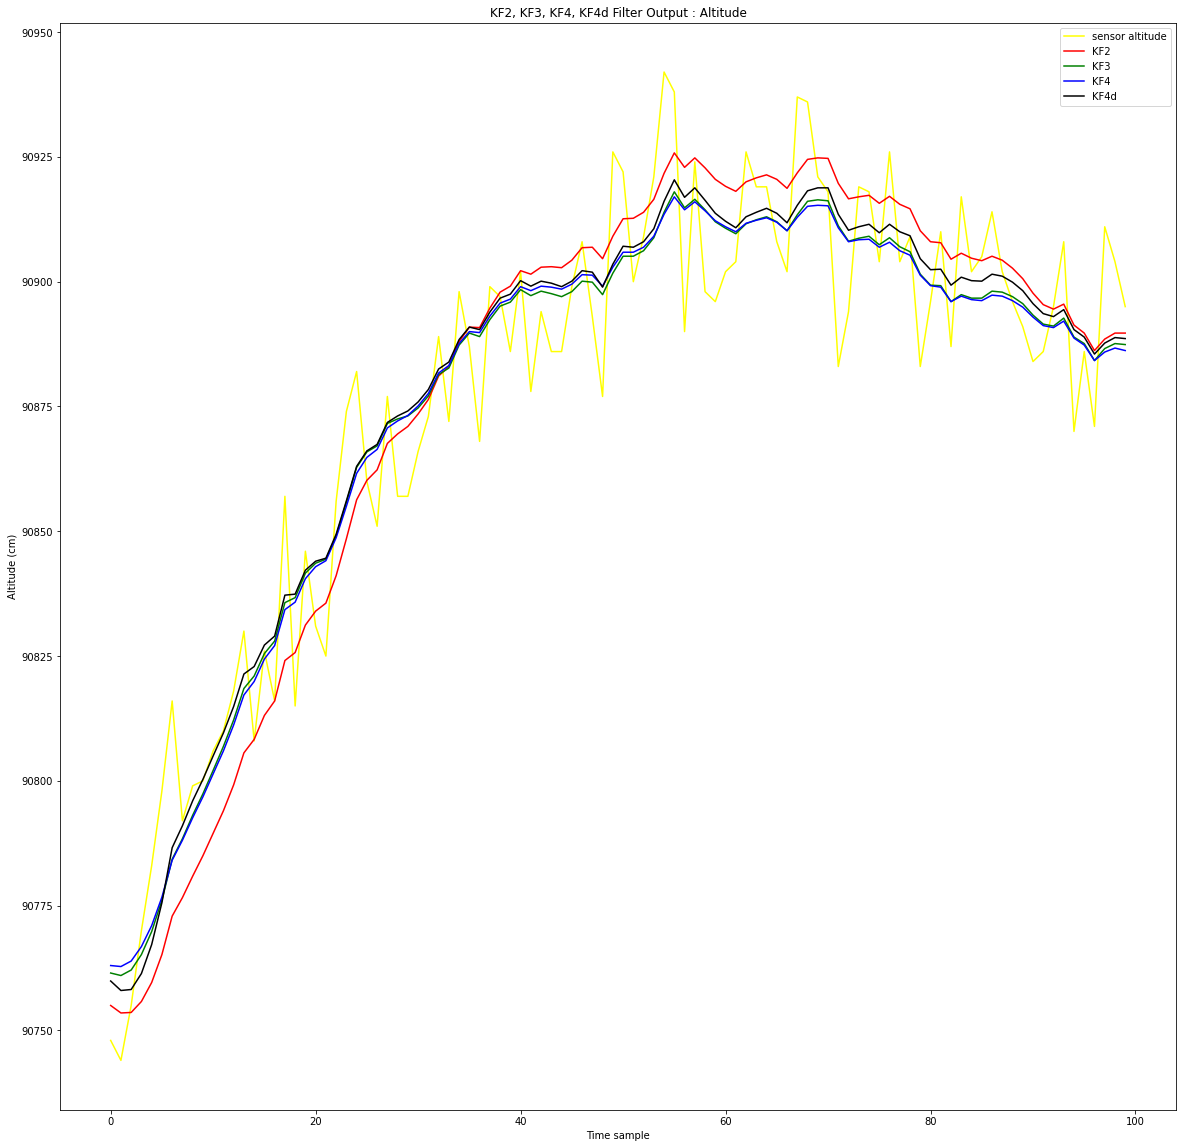

In [7]:
plt.plot(z[300:400], color='yellow', label='sensor altitude')
plt.plot(z_kf2[300:400], color='red', label='KF2')
plt.plot(z_kf3[300:400], color='green', label='KF3')
plt.plot(z_kf4[300:400], color='blue', label='KF4')
plt.plot(z_kf4_d[300:400], color='black', label='KF4d')
plt.xlabel('Time sample')
plt.ylabel('Altitude (cm)')
plt.title('KF2, KF3, KF4, KF4d Filter Output : Altitude')
plt.legend()
plt.show()

# Climb/sink rate estimation

The KF2 filter lag is clearly visible even without zooming in. The difference is very perceptible for variometer audio feedback.

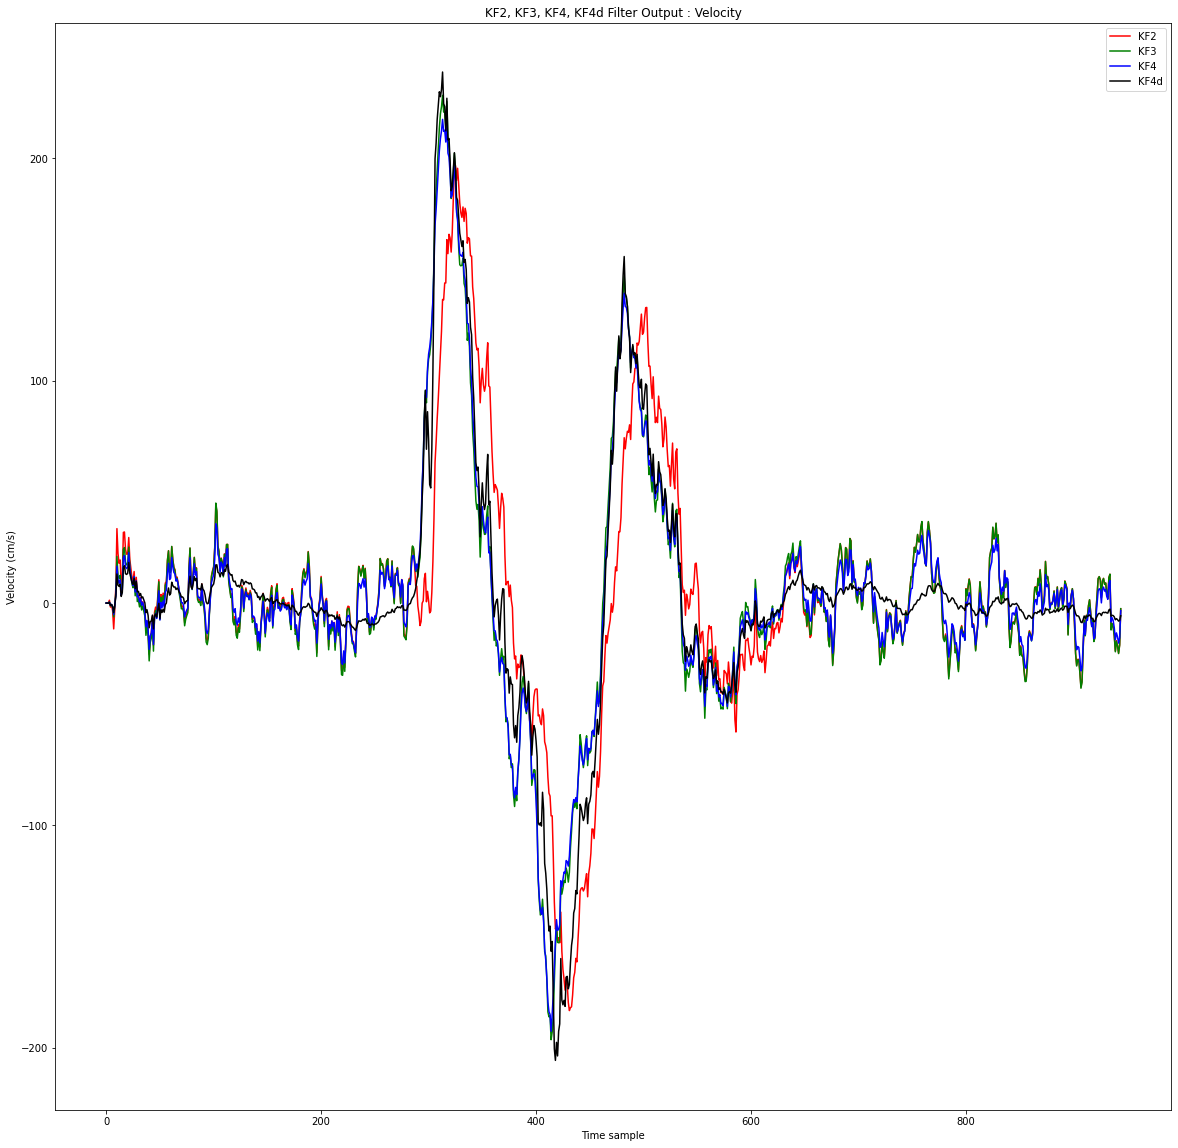

In [8]:
plt.plot(v_kf2, color='red', label='KF2')
plt.plot(v_kf3, color='green', label='KF3')
plt.plot(v_kf4, color='blue', label='KF4')
plt.plot(v_kf4_d, color='black', label='KF4d')
plt.title('KF2, KF3, KF4, KF4d Filter Output : Velocity')
plt.xlabel('Time sample')
plt.ylabel('Velocity (cm/s)')
plt.legend()
plt.show()

When zoomed in, we can quantify the difference in response. The sample interval is 20mS. KF2 responds to the falling variometer nearly 0.5 seconds later. This demonstrates the benefit of fusing acceleration and altitude readings for minimum-lag variometer response.

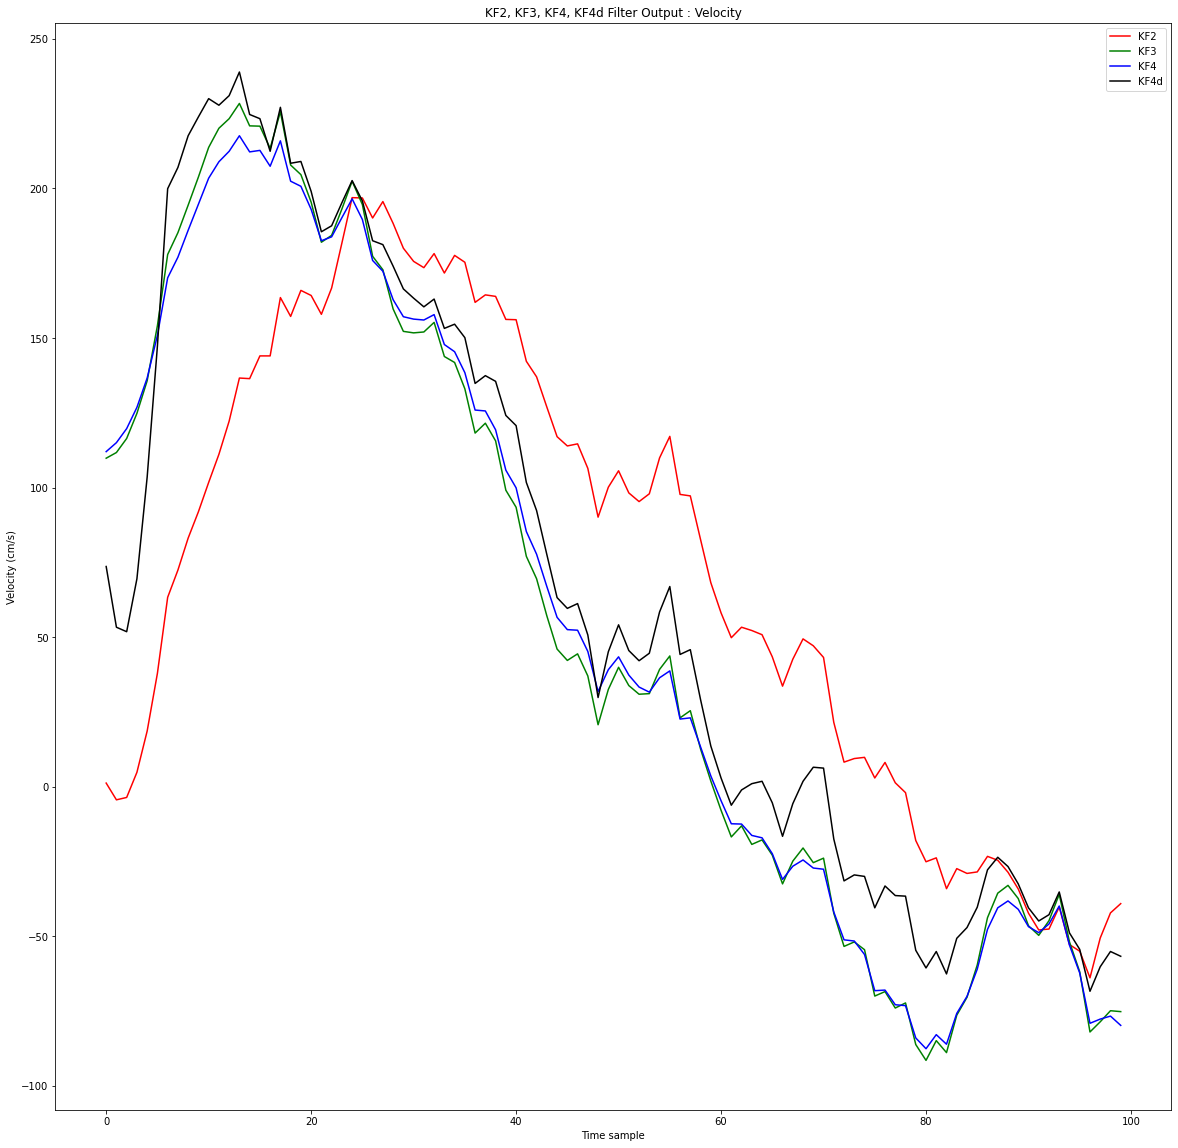

In [9]:
plt.plot(v_kf2[300:400], color='red', label='KF2')
plt.plot(v_kf3[300:400], color='green', label='KF3')
plt.plot(v_kf4[300:400], color='blue', label='KF4')
plt.plot(v_kf4_d[300:400], color='black', label='KF4d')
plt.title('KF2, KF3, KF4, KF4d Filter Output : Velocity')
plt.xlabel('Time sample')
plt.ylabel('Velocity (cm/s)')
plt.legend()
plt.show()

# Comparison of KF3, KF4 and KF4d algorithms (Covariance matrix P convergence)

In `config.h` choose the algorithm to run and set LOG_CONVERGENCE to 1.

E.g. if you want to check the KF3 algorithm convergence,
```
// choose one of the following tests
// print the kalman filter P convergence over first 512 samples of data
#define LOG_CONVERGENCE    1
// print the baro sensor derived altitude cm, and kalman filter estimates for z and v, for all samples
#define LOG_INPUT_OUTPUT   0

// choose one of the following algorithms  
// for LOG_CONVERGENCE run, only KF3 and KF4 are valid
#define USE_KF2 0
#define USE_KF3 1
#define USE_KF4 0

// For KF4 algorithm, set to 0, the acceleration and bias variances are configured as constants.
// For KF4d algorithm, set this to 1. It dynamically adds uncertainty to the Pvv and
// Pbb covariance elements depending on the magnitude of the environmental accelerations measured.
#define KF4_USE_DYNAMIC_ACCEL_BIAS_VARIANCE 1
```
Build the code :
```
g++ -o kf_compare kf_compare.cpp kalmanfilter2.cpp kalmanfilter3.cpp kalmanfilter4.cpp imu.cpp ringbuf.cpp -lm
```
Generate the results :
```
./kf_compare ./ms5611_datalog > kf3_ms5611_convergence.txt
```

In [10]:
z_kf3 = []
Pzz_kf3 = []
v_kf3 = []
Pvv_kf3 = []
with open('kf3_ms5611_convergence.txt', newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=' ')
    for row in csvreader:
        z_kf3.append(float(row[0]))
        Pzz_kf3.append(float(row[1]))
        v_kf3.append(float(row[2]))
        Pvv_kf3.append(float(row[3]))
z_kf3 = np.array(z_kf3)        
Pzz_kf3 = np.array(Pzz_kf3)
v_kf3 = np.array(v_kf3)        
Pvv_kf3 = np.array(Pvv_kf3)

In [11]:
z_kf4 = []
Pzz_kf4 = []
v_kf4 = []
Pvv_kf4 = []
with open('kf4_ms5611_convergence.txt', newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=' ')
    for row in csvreader:
        z_kf4.append(float(row[0]))
        Pzz_kf4.append(float(row[1]))
        v_kf4.append(float(row[2]))
        Pvv_kf4.append(float(row[3]))
z_kf4 = np.array(z_kf4)        
Pzz_kf4 = np.array(Pzz_kf4)
v_kf4 = np.array(v_kf4)        
Pvv_kf4 = np.array(Pvv_kf4)

In [12]:
z_kf4_d = []
Pzz_kf4_d = []
v_kf4_d = []
Pvv_kf4_d = []
with open('kf4d_ms5611_convergence.txt', newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=' ')
    for row in csvreader:
        z_kf4_d.append(float(row[0]))
        Pzz_kf4_d.append(float(row[1]))
        v_kf4_d.append(float(row[2]))
        Pvv_kf4_d.append(float(row[3]))
z_kf4_d = np.array(z_kf4_d)        
Pzz_kf4_d = np.array(Pzz_kf4_d)
v_kf4_d = np.array(v_kf4_d)        
Pvv_kf4_d = np.array(Pvv_kf4_d)

# Pzz convergence

Compare KF3, KF4 and KF4d altitude uncertainty convergence.

Note that for the KF4d algorithm we are artificially adding uncertainty to the state covariance matrix P elements Pvv and Pbb depending on the magnitude of the acceleration detected. This is the reason for the spikes in the regions where the vario is accelerating or decelerating. 

This is done to get a fast response to large accelerations while also filtering out noise better whenever the acceleration magnitude is low.

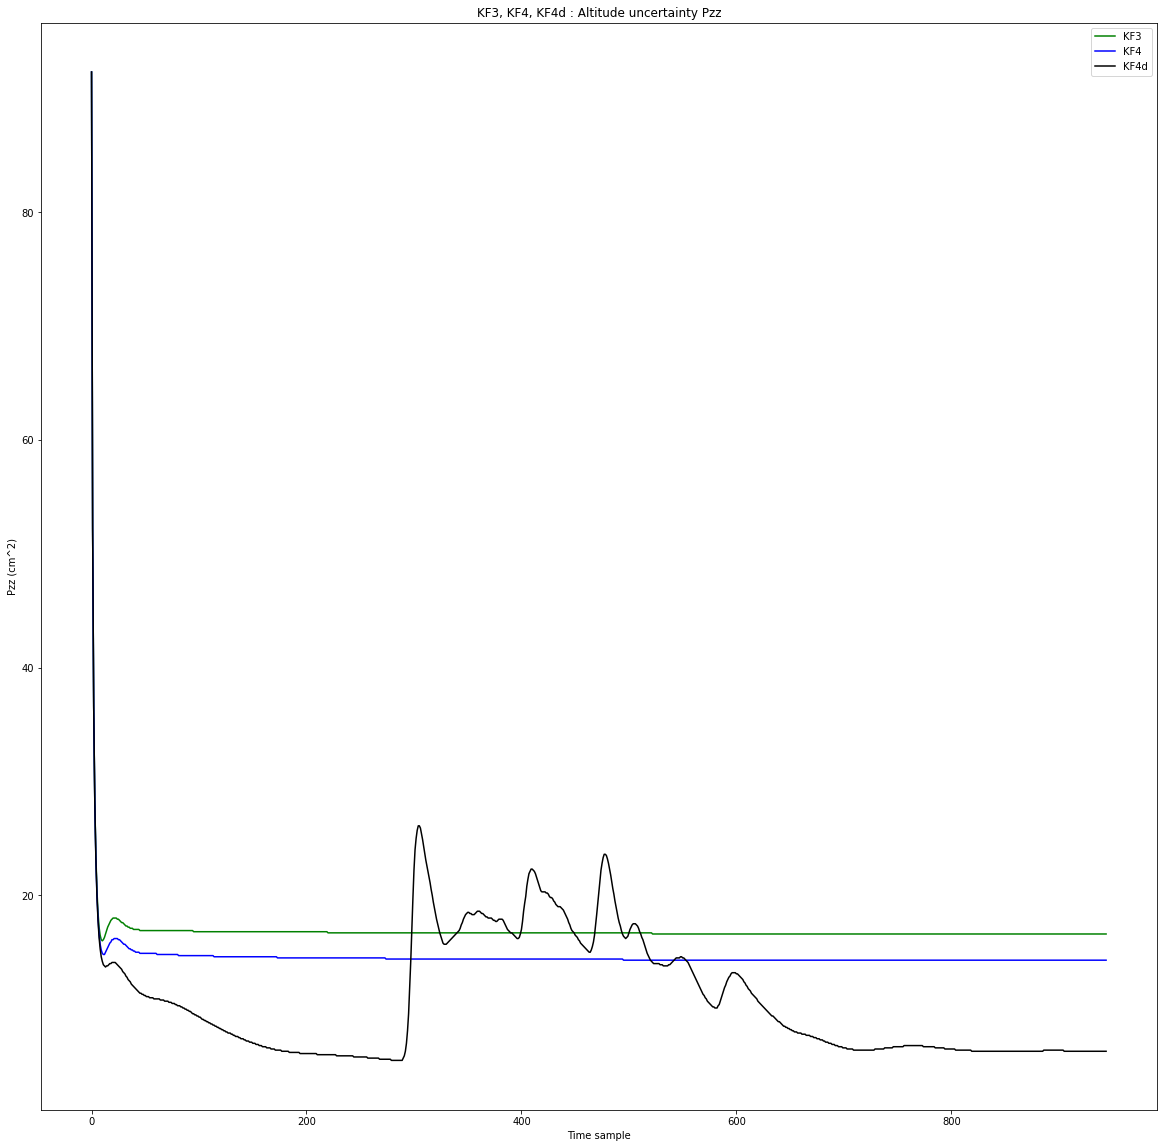

In [13]:
plt.plot(Pzz_kf3, color='green', label='KF3')
plt.plot(Pzz_kf4, color='blue', label='KF4')
plt.plot(Pzz_kf4_d, color='black', label='KF4d')
plt.title('KF3, KF4, KF4d : Altitude uncertainty Pzz')
plt.xlabel('Time sample')
plt.ylabel('Pzz (cm^2)')
plt.legend()
plt.show()

## Steep drop at start, so re-plot at starting offset 5 to clearly show the difference in converged levels

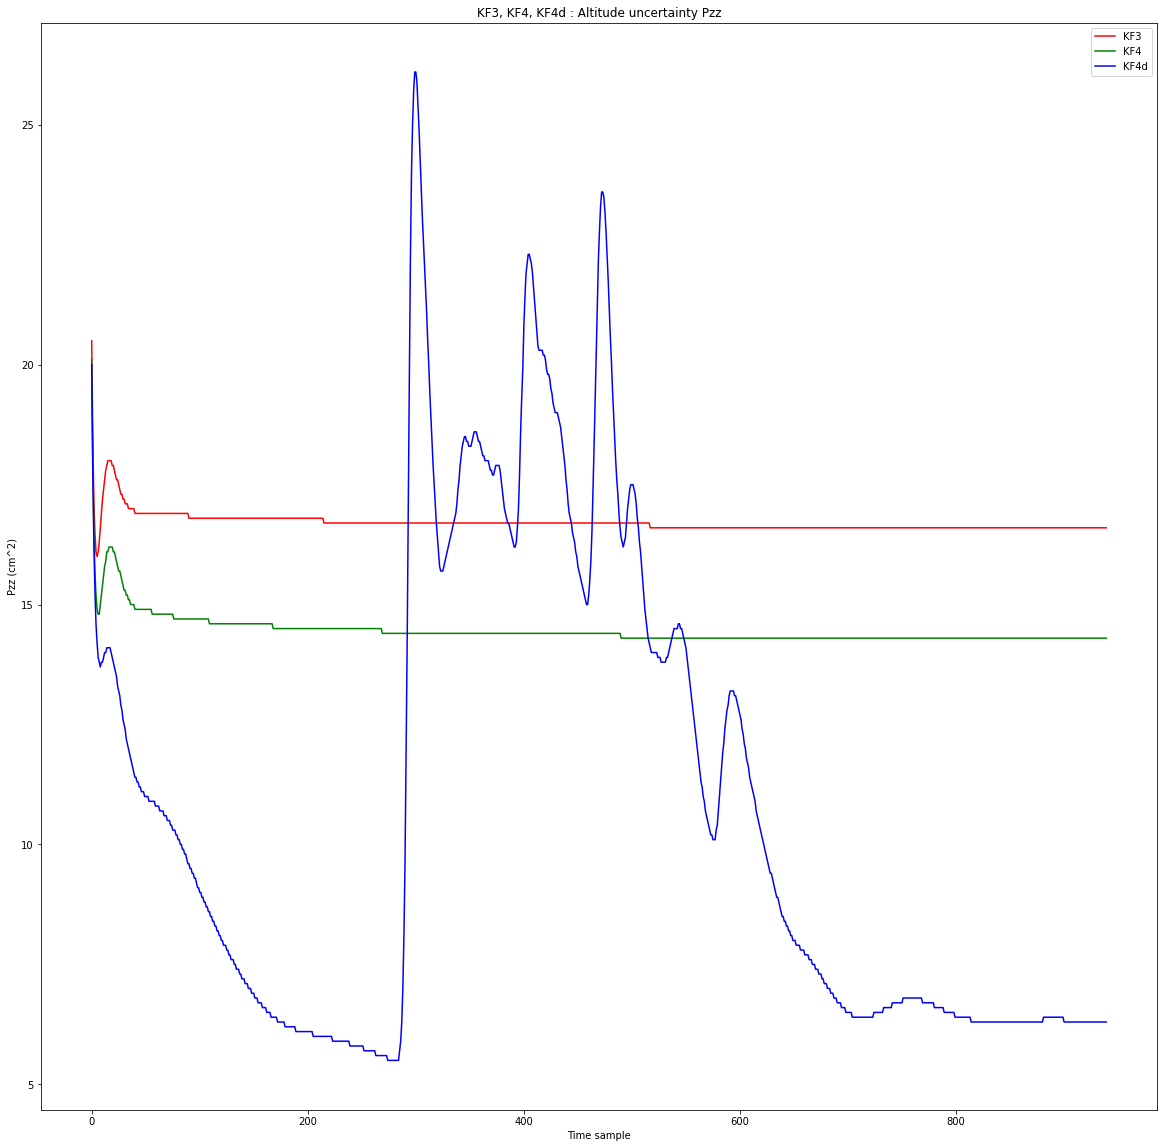

In [14]:
plt.plot(Pzz_kf3[5:], color='red', label='KF3')
plt.plot(Pzz_kf4[5:], color='green', label='KF4')
plt.plot(Pzz_kf4_d[5:], color='blue', label='KF4d')
plt.title('KF3, KF4, KF4d : Altitude uncertainty Pzz')
plt.xlabel('Time sample')
plt.ylabel('Pzz (cm^2)')
plt.legend()
plt.show()

# Pvv convergence

Compare KF3, KF4 and KF4d velocity uncertainty convergence. 

Note that for the KF4d algorithm we are artificially adding uncertainty to the covariance matrix P elements Pvv and Pbb depending on the magnitude of the detected acceleration. This is the reason for the spikes in the regions where the vario is accelerating or decelerating. 

This is done to get a fast response to large accelerations while also filtering out noise better whenever the acceleration magnitude is low.

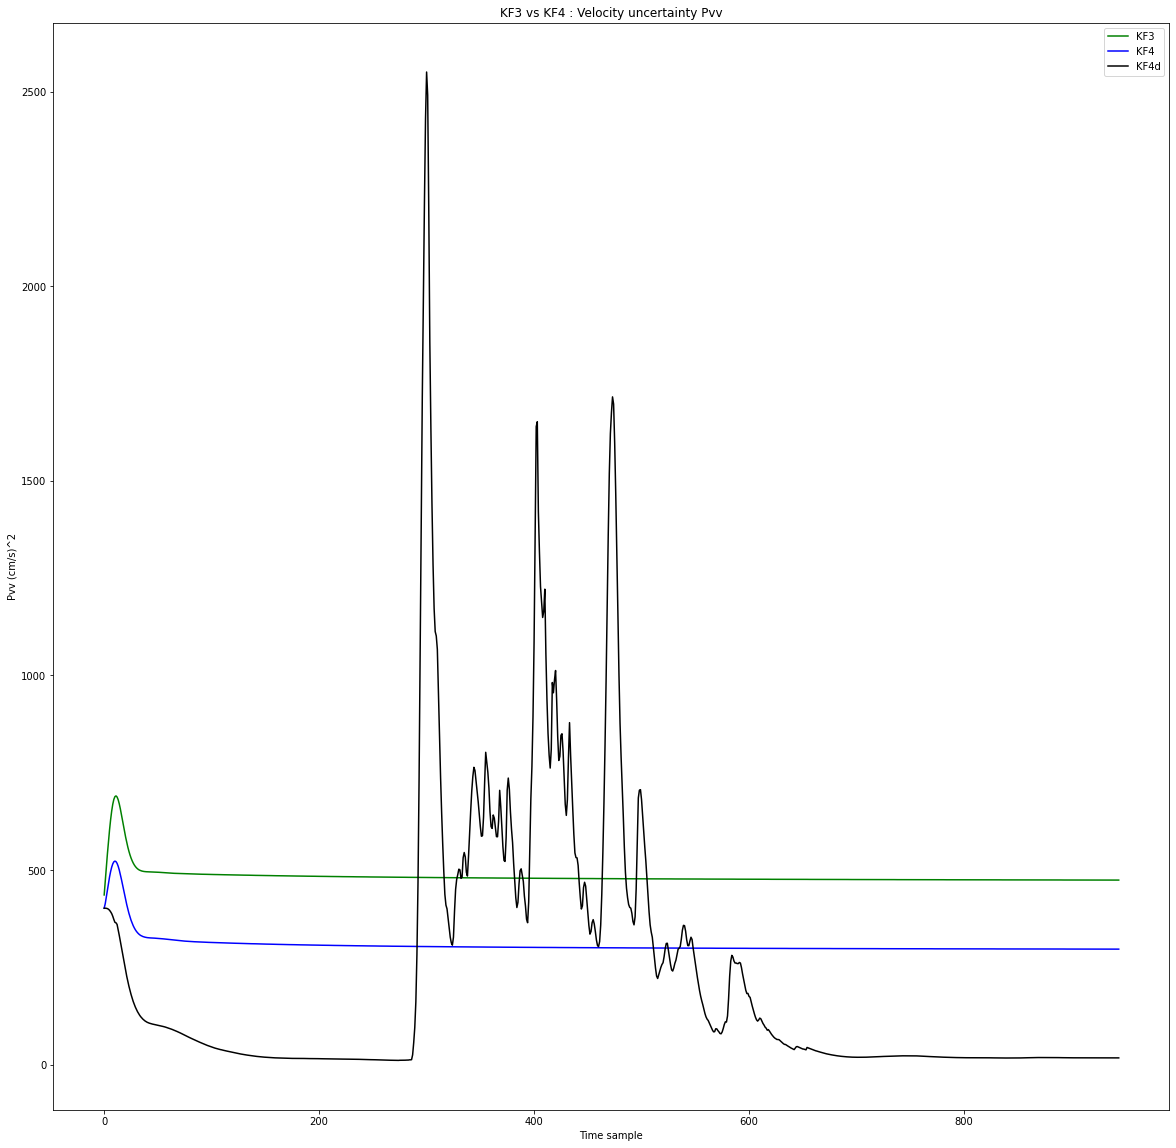

In [15]:
plt.plot(Pvv_kf3, color='green', label='KF3')
plt.plot(Pvv_kf4, color='blue', label='KF4')
plt.plot(Pvv_kf4_d, color='black', label='KF4d')
plt.xlabel('Time sample')
plt.ylabel('Pvv (cm/s)^2')
plt.title('KF3 vs KF4 : Velocity uncertainty Pvv')
plt.legend()
plt.show()

# Pzz and Pvv at end of log (vario stationary)

|  | Pzz | Pvv |
| --- | --- | --- |
| KF3 | 16.6  | 474.2 |
| KF4 | 14.3 | 296.8 |
| KF4d | 6.3 | 17.4 |

The KF4d algorithm with dynamic accel/bias uncertainty injection has significantly lower climb/sinkrate uncertainty when the external acceleration perturbations are low (i.e. at rest or moving with near constant velocity). 

In terms of perceptible variometer audio feedback, there is much less jitter when the vario is stationary or moving with constant velocity. The trade-off is that there is a slight delay compared to the KF4 algorithm for low accelerations/decelerations. K4d is my preferred algorithm option.